In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from nltk.tokenize import RegexpTokenizer
import numpy as np
import re
import pandas as pd
from sklearn.model_selection import train_test_split


In [ ]:
import os

In [ ]:
os.chdir( "/content/drive/My Drive/PES_MTech_inperson/S3_S4")

### Load the dataset from the disk

In [ ]:
import pandas as pd
df = pd.read_csv('complaints.csv') # We are taking less rows for faster execution
df.head()

,Consumer complaint narrative,Product
0,I have outdated information on my credit repor...,Credit reporting
1,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
2,An account on my credit report has a mistaken ...,Credit reporting
3,This company refuses to provide me verificatio...,Debt collection
4,This complaint is in regards to Square Two Fin...,Debt collection


In [ ]:
df.shape

(179776, 2)

In [ ]:
df['Product'].value_counts()

,count
Product,
Debt collection,43946
Mortgage,34576
Credit reporting,31589
Credit card,18845
Bank account or service,14892
Student loan,12047
Consumer Loan,9486
"Credit reporting, credit repair services, or other personal consumer reports",6118
Payday loan,1750


<Axes: xlabel='Product'>

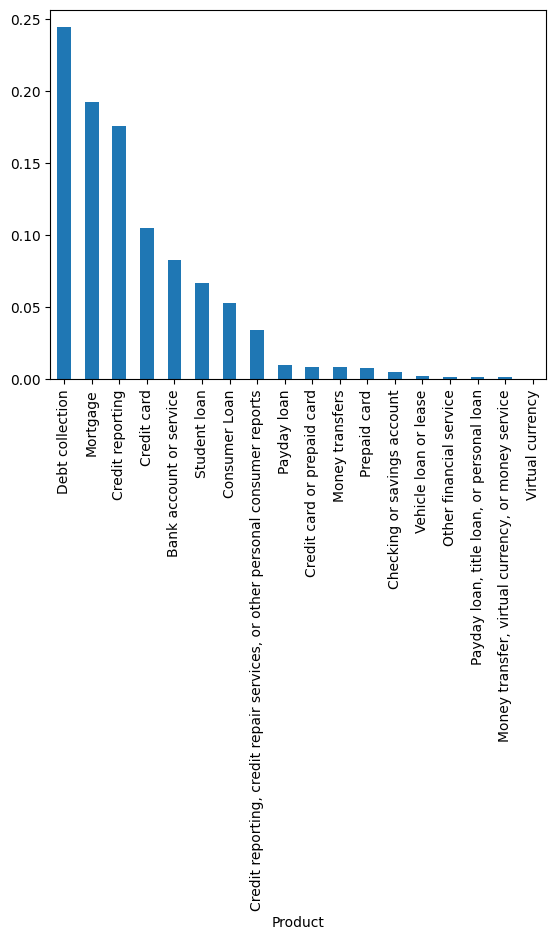

In [ ]:
df['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
stratify_column = 'Product'

In [ ]:
df_prod, _=train_test_split(df, test_size=0.5, stratify=df[stratify_column], random_state=42)

In [ ]:
df.shape

(179776, 2)

In [ ]:
df_prod.shape

(89888, 2)

<Axes: xlabel='Product'>

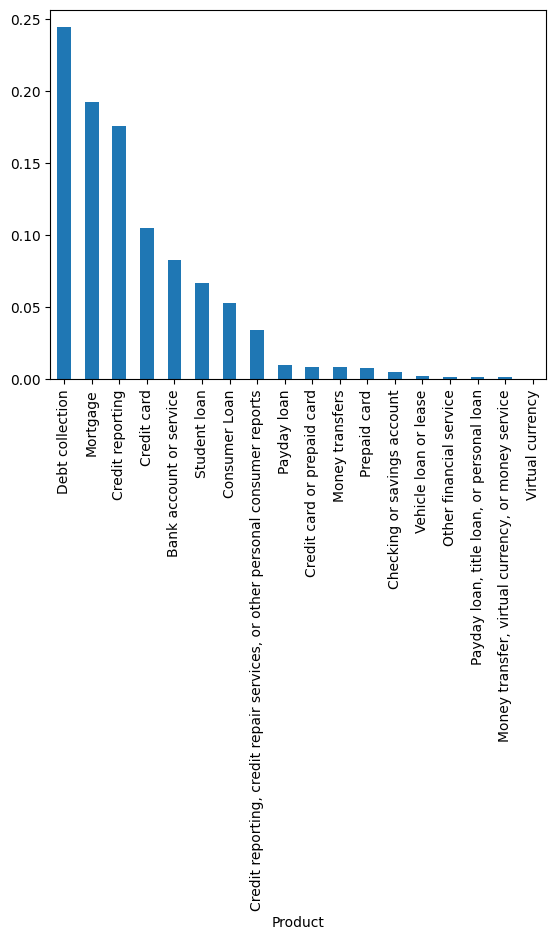

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
threshold=0.05

In [ ]:
values_below_threshold = df_prod['Product'].value_counts(normalize=True)
values_below_threshold = values_below_threshold[df_prod['Product'].value_counts(normalize=True) <=threshold ].index.tolist()

In [ ]:
values_below_threshold

['Credit reporting, credit repair services, or other personal consumer reports',
 'Payday loan',
 'Credit card or prepaid card',
 'Money transfers',
 'Prepaid card',
 'Checking or savings account',
 'Vehicle loan or lease',
 'Other financial service',
 'Payday loan, title loan, or personal loan',
 'Money transfer, virtual currency, or money service',
 'Virtual currency']

In [ ]:
len(values_below_threshold)

11

In [ ]:
df_prod['Product'] = df_prod['Product'].apply(lambda x: 'Other' if x in values_below_threshold else x)

<Axes: xlabel='Product'>

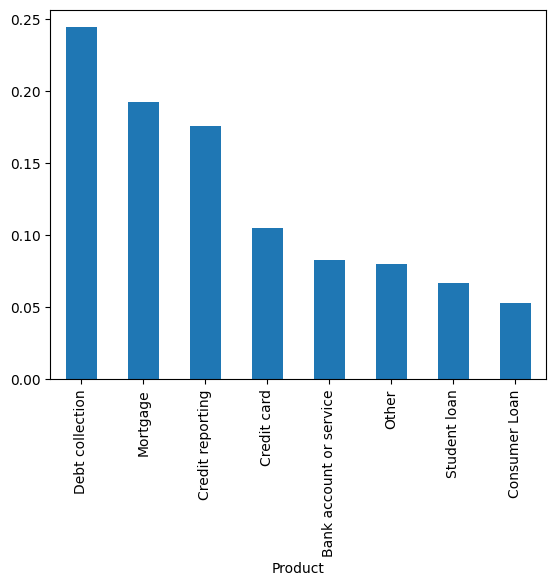

In [ ]:
df_prod['Product'].value_counts(normalize=True).plot(kind='bar')

In [ ]:
df_prod.isnull().sum()

,0
Consumer complaint narrative,0
Product,0


### Tokenizer
Regular expression based tokenizers to consider only alphabetical sequences and ignore numerical sequences.

In [ ]:
def cleanup(text):

    #words = comp.lower().split()
    alphabets_only = re.sub("[^a-zA-Z\s]", "", text) # Remove non-alphabetic characters
    alphabets_only = re.sub("\d+", "", alphabets_only)  # Remove digits explicitly
    alphabets_only = re.sub("\s+", " ", alphabets_only).strip() # Remove extra spaces
    return alphabets_only.lower()

In [ ]:
df_prod['Consumer complaint narrative']=df_prod['Consumer complaint narrative'].apply(cleanup)

### Vocabulary
Extracing all the unique words from the dataset

In [ ]:
def complaint_to_words(text) -> list:
    return text.split()

In [ ]:
all_words = list()
for comp in df_prod['Consumer complaint narrative']:
    for w in complaint_to_words(comp):
        all_words.append(w)

In [ ]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 70695


In [ ]:
print('Complaint\n', df_prod['Consumer complaint narrative'].iloc[10], '\n')
print('Tokens\n', complaint_to_words(df_prod['Consumer complaint narrative'].iloc[10]))

Complaint
 first federal credit account numbers xxxx xxxxxxxxxxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx phone xxxx attention to dispute department dear sir or madam i am a victim of identity theft an identity thief used my personal information without my permission to open an account several account in my name this debt is not mine i have enclosed proof of my identity and a copy of my identity theft report in accordance with the fair debt collection practices act i am asking you to stop collection proceedings against me and stop communicating with me about this debt except as the fair credit reporting act allows i also ask that you first federal credit or any company associate with this account xxxx and tell them the debt is the result of identity theft i have enclosed a copy of the federal trade commission s police report notice to furnishers of information it explains your responsibilities under the fair credit reporting act fcra the fcra requires that debt collectors give an ident

In [ ]:
df_prod.sample(10)

,Consumer complaint narrative,Product
96781,dear consumer financial protection bureau amid...,Student loan
119294,hello i need help wells fargo claims i have a ...,Mortgage
95701,my mortgage servicer ocwen has flagged my acco...,Mortgage
10802,i previously had an identity theft situation x...,Debt collection
74592,hello my name is xxxx xxxx the credit report t...,Credit reporting
52592,gym owner offered month membership for xxxx mo...,Debt collection
152543,sometime between xxxxxxxx and xxxx citizens ba...,Bank account or service
82016,i received a debt collection letter from lvnv ...,Debt collection
123881,i have had a very difficult time with rushmore...,Mortgage
52726,on or about xxxx xxxx i received a phone call ...,Debt collection


### TRANSFORMER based training

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print('connected to a GPU')
  print('-'*80)
  print(gpu_info)

connected to a GPU
--------------------------------------------------------------------------------
Sat Nov 23 02:03:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              33W /  70W |   8325MiB / 15360MiB |      0%      Default |
|                                         |               

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
df_prod['Product_code'] = le.fit_transform(df_prod['Product'])

In [ ]:
df_prod.head(5)

,Consumer complaint narrative,Product,Product_code
121878,made a xxxx payment on my line of credit loc v...,Consumer Loan,1
125261,xxxx xxxx xxxx and xxxx xxxx xxxx have promise...,Debt collection,4
23818,in a chat conversation with xxxx who requested...,Credit reporting,3
79241,we had a major flood insurance check made paya...,Other,6
147039,barclaycard posted my payment to the wrong cre...,Credit card,2


In [ ]:
NUM_CLS=df_prod['Product'].nunique()
print (NUM_CLS)

8


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
MODEL_TYPE = 'bert-base-uncased'#'bert-large-uncased'#
MAX_LENGTH = 132
TRAIN_TARGET='Product_code'
TRAIN_FEATURE='Consumer complaint narrative'

In [ ]:
try:
    # Clear cache and download again
    tokenizer =BertTokenizer.from_pretrained(MODEL_TYPE, force_download=True)
    print("*"*50)
    print(f"{MODEL_TYPE} Tokenizer downloaded and loaded successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

**************************************************
bert-base-uncased Tokenizer downloaded and loaded successfully!


In [ ]:
try:
    # Clear cache and download again
    model = TFBertForSequenceClassification.from_pretrained(MODEL_TYPE, num_labels=NUM_CLS,force_download=True)
    print("*"*50)
    print(f"{MODEL_TYPE} Seq classifier downloaded and loaded successfully!")
except Exception as e:
    print(f"An error occurred: {e}")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**************************************************
bert-base-uncased Seq classifier downloaded and loaded successfully!


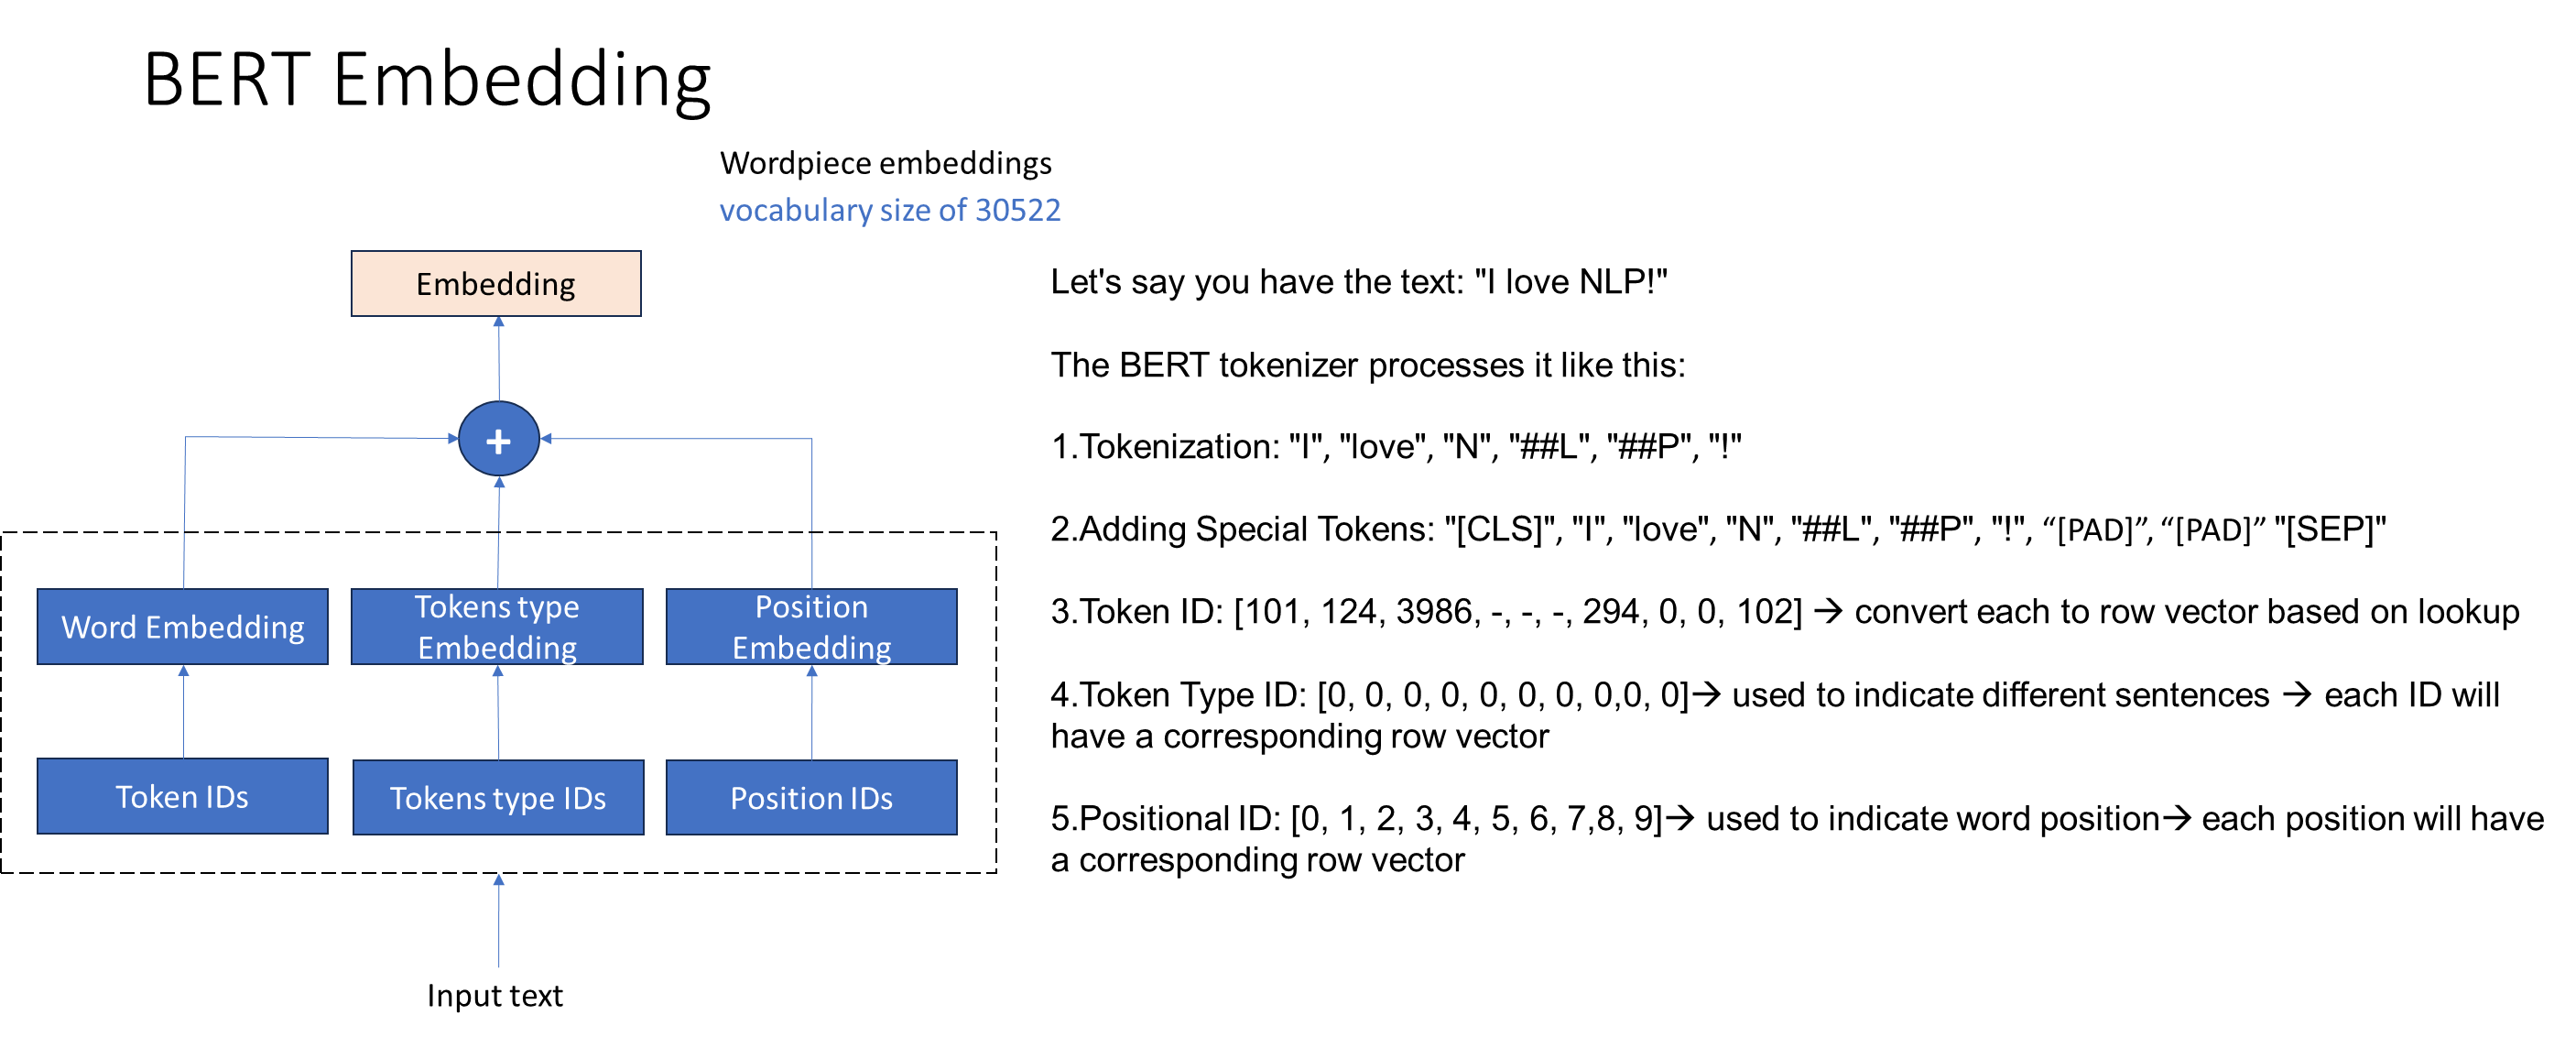

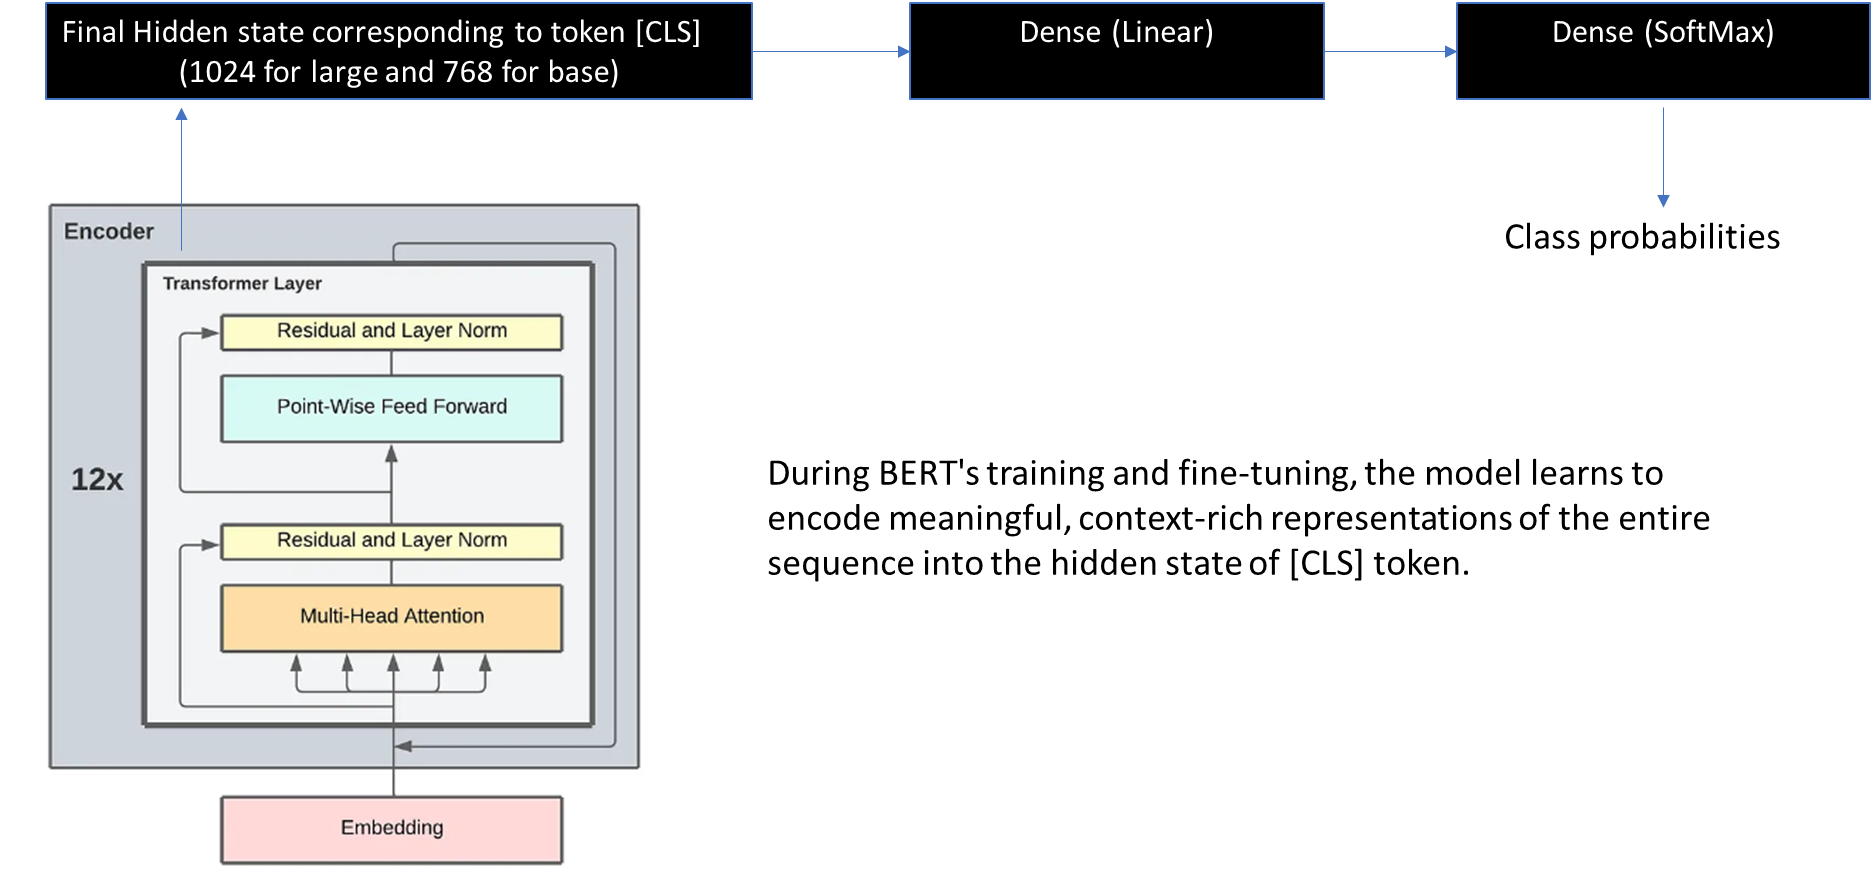

In [ ]:
df_train, df_test = train_test_split(df_prod[[TRAIN_FEATURE,TRAIN_TARGET]], test_size=0.25, random_state=500,)

In [ ]:
df_val, df_test = train_test_split(df_test[[TRAIN_FEATURE,TRAIN_TARGET]], test_size=0.5, random_state=500,)

In [ ]:

train_encodings = tokenizer(list(df_train[TRAIN_FEATURE].values),
                            truncation=True,
                            padding=True,
                            max_length=MAX_LENGTH)
val_encodings = tokenizer(list(df_val[TRAIN_FEATURE].values),
                           truncation=True,
                           padding=True,
                           max_length=MAX_LENGTH)
test_encodings = tokenizer(list(df_test[TRAIN_FEATURE].values),
                           truncation=True,
                           padding=True,
                           max_length=MAX_LENGTH)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    df_train[TRAIN_TARGET].values
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    df_val[TRAIN_TARGET].values
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    df_test[TRAIN_TARGET].values
))


In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(len(df_train)).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
model.optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile( loss=loss, metrics=['accuracy'])

In [ ]:
# Train the model
history=model.fit(train_dataset, epochs=50,validation_data=val_dataset)

Epoch 1/50
703/703 [==============================] - 904s 1s/step - loss: 1.9778 - accuracy: 0.2299 - val_loss: 1.9818 - val_accuracy: 0.1930
Epoch 2/50
703/703 [==============================] - 876s 1s/step - loss: 1.9621 - accuracy: 0.2380 - val_loss: 1.9585 - val_accuracy: 0.2449
Epoch 3/50
703/703 [==============================] - 876s 1s/step - loss: 1.9605 - accuracy: 0.2410 - val_loss: 1.9554 - val_accuracy: 0.2449
Epoch 4/50
703/703 [==============================] - 875s 1s/step - loss: 1.9590 - accuracy: 0.2396 - val_loss: 1.9546 - val_accuracy: 0.2449
Epoch 5/50
703/703 [==============================] - 876s 1s/step - loss: 1.9590 - accuracy: 0.2400 - val_loss: 1.9582 - val_accuracy: 0.2449
Epoch 6/50
703/703 [==============================] - 876s 1s/step - loss: 1.9580 - accuracy: 0.2415 - val_loss: 1.9583 - val_accuracy: 0.2449
Epoch 7/50
703/703 [==============================] - 877s 1s/step - loss: 1.9560 - accuracy: 0.2427 - val_loss: 1.9550 - val_accuracy: 0.2449

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy:.4f}")

In [ ]:
preds=model.predict(test_dataset)

In [ ]:
logits = preds['logits']
preds = np.argmax(logits, axis=1)

In [ ]:
preds

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
# Example true and predicted labels
y_true = list(df_test[TRAIN_TARGET])  # True labels
y_pred = preds  # Predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define the labels for the confusion matrix
labels = np.unique(y_true)

# Create the plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Add labels and titles
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
class_report = classification_report(y_true, y_pred)
print(class_report)

In [ ]:
model.save('bert_model')

In [ ]:
tokenizer.save_pretrained('bert_tokenizer')